In [1]:
from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:

WANDB_ACTIVE = False


In [8]:
import os
import sys
import csv
import json
import time
import types, copy, pprint
import logging 
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
# import shutil
# import getpass
import yaml

import hydra 
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf


from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torchinfo import summary
import wandb

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
print(torch.__version__)

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "development.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/cytominer_eval-0.1-py3.11.egg']
2.2.1+cu118


In [10]:
# Soft Nearest Neighbor Loss
# Copyright (C) 2020  Abien Fred Agarap
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as published
# by the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.
#
# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.
__author__ = "Abien Fred Agarap"
__version__ = "1.0.0"
"""Sample module for using DNN classifier with SNNL"""

from KevinsRoutines.utils.utils_wandb  import  init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general  import  list_namespace, print_heading, print_underline 
from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from snnl.utils import load_model, save_model, import_results, export_results, save_checkpoint, load_checkpoint 
from snnl.utils import plot_model_parms, plot_train_history, plot_classification_metrics, plot_regression_metrics
from snnl.utils import display_epoch_metrics, display_cellpainting_batch, display_model_parameters
from snnl.utils import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn
from snnl.utils import display_model_summary, define_autoencoder_model
from snnl.utils import save_checkpoint_v2, load_checkpoint_v2, save_checkpoint_v3

from snnl.models import Model
# from dev_dnn  import DNN 
# from dev_autoencoder import Autoencoder
# from dev_snnloss import SNNLoss

'Sample module for using DNN classifier with SNNL'

In [ ]:
from scipy.spatial.distance import pdist, squareform, euclidean

In [11]:
current_device = get_device()
print(f"Current device is : {current_device}")

2024-07-03 20:26:15,359 - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100


Current device is : cuda:0


In [6]:
# if __name__ == "__main__":
input_args = f" --seed               1234 " \
             f" --runmode            snnl" \
             f" --configuration      hyperparameters/autoencoder_cellpainting.yaml"
             # f" --configuration    hyperparameters/dnn_mnist.json"
             # f" --model             baseline" \
args = parse_args(input_args.split())
args

with open(args.configuration) as f:
    args = types.SimpleNamespace(**yaml.safe_load(f), **(vars(args)))
args.batch_size = args.cellpainting_args['batch_size']
args.compounds_per_batch = args.cellpainting_args['compounds_per_batch']
set_global_seed(args.seed)


Namespace(seed=1234, runmode='snnl', configuration='hyperparameters/autoencoder_cellpainting.yaml')

In [28]:
def plot_xy(x,y, title = 'X-Y Plot', start= 0, n_bins = 25):
    key1 = 'trn'     
    fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(1*4,4) )
    # x_data = np.arange(start,epochs)
    labelsize = 6
    # We can set the number of bins with the *bins* keyword argument.
    _ = axs.plot(x, y, label='Training');
    # _ = axs[i].plot(x_data, model.training_history['val']['val_ttl_loss'][start:epochs],label='Validation');
    _ = axs.set_title(title, fontsize= 10);
    _ = axs.tick_params(axis='both', which='major', labelsize=6, labelrotation=45)
    axs.legend()

In [17]:
x = np.arange(700)
y = 1.0 / ((1.0 + x) ** 0.55)

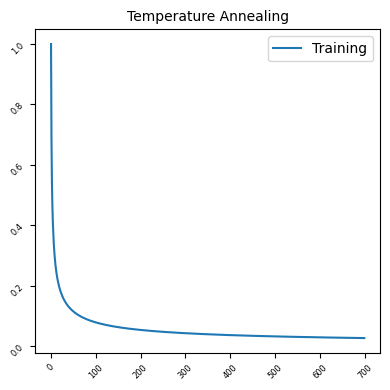

In [30]:
plot_xy(x,y, 'Temperature Annealing')

In [32]:
for i, j in zip (x,y):
    if i % 100 == 0:
        print(f" {i:4d}      {j:.5f}")
        
print(f" {i:4d}      {j:.5f}")

    0      1.00000
  100      0.07900
  200      0.05411
  300      0.04333
  400      0.03701
  500      0.03274
  600      0.02962
  699      0.02724


In [7]:
trn_file_sz = args.cellpainting_args['train_end'] - args.cellpainting_args['train_start']
val_file_sz = args.cellpainting_args['val_end'] - args.cellpainting_args['val_start']
smp_sz = args.cellpainting_args['sample_size']
buf_sz = args.cellpainting_args['compounds_per_batch']
bth_sz = args.cellpainting_args['batch_size']
recs_per_batch = smp_sz * bth_sz * buf_sz

for file_sz in [trn_file_sz, val_file_sz]:
    bth_per_epoch = file_sz // recs_per_batch
    print(f" - Each mini-batch contains {recs_per_batch/smp_sz} compounds with {smp_sz} samples per each compound : total {recs_per_batch} rows")
    print(f" - Number of {recs_per_batch} row full size batches per epoch: {bth_per_epoch}")
    print(f" - Rows covered by {bth_per_epoch} full size batches ({recs_per_batch} rows) per epoch:  {(file_sz // recs_per_batch) * recs_per_batch}")
    print(f" - Last partial batch contains : {file_sz % recs_per_batch} rows")
    print() 

 - Each mini-batch contains 100.0 compounds with 3 samples per each compound : total 300 rows
 - Number of 300 row full size batches per epoch: 800
 - Rows covered by 800 full size batches (300 rows) per epoch:  240000
 - Last partial batch contains : 0 rows

 - Each mini-batch contains 100.0 compounds with 3 samples per each compound : total 300 rows
 - Number of 300 row full size batches per epoch: 80
 - Rows covered by 80 full size batches (300 rows) per epoch:  24000
 - Last partial batch contains : 0 rows



In [8]:
args.project_name = 'CellPainting_Profiles'
args.exp_id   = None
args.exp_name = 'AE_'+datetime.now().strftime('%m%d_%H%M')
args.exp_title = 'secondTry'
args.exp_desc = 'Autoencoder Training in SNNL mode'+' - '+args.exp_title
args.exp_date = datetime.now().strftime('%Y%m%d')
print(f" Experiment name {args.exp_name} - description: {args.exp_desc}")

 Experiment name AE_0510_1221 - description: Autoencoder Training in SNNL mode - secondTry


In [9]:
if WANDB_ACTIVE:
    wandb_run = init_wandb(args)

# Define autoencoder model

## Override arguments

In [89]:
# args.show_every = 1
# args.save_every = 25
# args.temperature   = 5.00
# args.loss_factor   = 4.0        ## 2.0e+00
# args.snnl_factor   = 0.25       ## 1.0e+00
# args.learning_rate = 1.0e-02    ## 0.001
# args.temperatureLR = 1.0e-03    ## 1e-4
print(f"   Latent dim        {args.code_units}")
print(f"   loss_factor       {args.loss_factor}")
print(f"   snnl_factor       {args.snnl_factor}")
print(f"   temperature       {args.temperature}")
print(f"   learning_rate     {args.learning_rate}")
print(f"   temperatureLR:    {args.temperatureLR}")

   Latent dim        50
   loss_factor       2.0
   snnl_factor       1.0
   temperature       50.0
   learning_rate     0.0001
   temperatureLR:    0.01


In [90]:
list_namespace(args)


command line parms : 
-----------------------
activations..............  ['relu', 'relu', 'sigmoid', 'relu', 'relu', 'relu']
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  100
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_start................  0
    validation_path..........  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv

code_units...............  50
compounds_per_batch...

## Define Model

In [91]:
if args.runmode.lower() == "baseline":
    print(f"Defining model in baseline mode")
    model = Autoencoder(
        units=args.units,
        activations = args.activations,
        code_units  = args.code_units, 
        criterion   = torch.nn.MSELoss(reduction='mean'),
        input_shape = args.input_shape, 
        sample_size = args.cellpainting_args['sample_size'],
        loss_factor = args.loss_factor,
        snnl_factor=args.snnl_factor,
        learning_rate=args.learning_rate,
        embedding_layer = 4,
        use_scheduler = False,
        use_temp_scheduler = False,
        )
elif args.runmode.lower() == "snnl":
    print(f"Defining model in SNNL mode ")
    model = Autoencoder(
        mode="latent_code",
        units=args.units,
        activations = args.activations,
        code_units = args.code_units,
        input_shape=args.input_shape,
        sample_size = args.cellpainting_args['sample_size'],
        criterion = torch.nn.MSELoss(reduction='mean'),
        loss_factor = args.loss_factor,
        learning_rate=args.learning_rate,
        use_snnl=True,
        snnl_factor=args.snnl_factor,
        temperature=args.temperature,
        use_annealing= False,        
        use_sum = False,
        temperatureLR=args.temperatureLR,
        adam_weight_decay = 0,
        SGD_weight_decay= 0,
        embedding_layer = 4,
        use_scheduler = False,
        use_temp_scheduler = False,

        )
else:
    raise ValueError("Choose runmode between [baseline] and [snnl] only.")
model.device

if WANDB_ACTIVE:
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = True)

Defining model in SNNL mode 

------------------------------------------------------------
 Building Base Model from NOTEBOOK
------------------------------------------------------------
    Model_init()_    -- mode:              latent_code
    Model_init()_    -- unsupervised :     None
    Model_init()_    -- Criterion:         MSELoss()
    Model_init()_    -- use_snnl :         True
    Model_init()_    -- temperature :      50.0
    Model_init()_    -- temperature LR:    0.01
    Model_init()_    -- AE - support for unsupervised in latent_code mode is True

------------------------------------------------------------
 Build SNNLoss from NOTEBOOK
------------------------------------------------------------
    SNNLoss _init()_    -- mode: latent_code was found in SNNLoss._supported_modes --   is unsupervised: True
    SNNLoss _init()_    -- unsupervised :     True
    SNNLoss _init()_    -- use_annealing :    False
    SNNLoss _init()_    -- sample_size :      3
    SNNLoss _init(

device(type='cuda', index=0)

# Distances

In [10]:
def pairwise_cosine_distance(features: torch.Tensor) -> torch.Tensor:
    """
    Returns the pairwise cosine distance between two copies
    of the features matrix.

    Parameter
    ---------
    features: torch.Tensor
        The input features.

    Returns
    -------
    distance_matrix: torch.Tensor
        The pairwise cosine distance matrix.

    Example
    -------
    >>> import torch
    >>> from snnl import SNNLoss
    >>> _ = torch.manual_seed(42)
    >>> a = torch.rand((4, 2))
    >>> snnl = SNNLoss(temperature=1.0)
    >>> snnl.pairwise_cosine_distance(a)
    tensor([[1.1921e-07, 7.4125e-02, 1.8179e-02, 1.0152e-01],
            [7.4125e-02, 1.1921e-07, 1.9241e-02, 2.2473e-03],
            [1.8179e-02, 1.9241e-02, 1.1921e-07, 3.4526e-02],
            [1.0152e-01, 2.2473e-03, 3.4526e-02, 0.0000e+00]])
    """
    normalized_a = torch.nn.functional.normalize(features, dim=1, p=2)
    return 1.0 - torch.matmul(normalized_a, normalized_a.T)
    
    # a, b = features.clone(), features.clone()
    # normalized_a = torch.nn.functional.normalize(a, dim=1, p=2)
    # normalized_b = torch.nn.functional.normalize(b, dim=1, p=2)
    # normalized_b = torch.conj(normalized_b).T
    # product = torch.matmul(normalized_a, normalized_b.T)
    # distance_matrix = torch.sub(torch.tensor(1.0), product)
    # return torch.sub(torch.tensor(1.0), product)
    # return distance_matrix    
    
def pairwise_euclidean_distance(features: torch.Tensor ) -> torch.Tensor:
    """
    Returns the pairwise Euclidean distance between two copies
    of the features matrix.

    Parameter
    ---------
    features: torch.Tensor
        The input features.

    Returns
    -------
    distance_matrix: torch.Tensor
        The pairwise Euclidean distance matrix.

    Example
    -------
    >>> import torch
    >>> from snnl import SNNLoss
    >>> _ = torch.manual_seed(42)
    >>> a = torch.rand((4, 2))
    >>> snnl = SNNLoss(temperature=1.0)
    >>> snnl.pairwise_euclidean_distance(a)
    tensor([[1.1921e-07, 7.4125e-02, 1.8179e-02, 1.0152e-01],
            [7.4125e-02, 1.1921e-07, 1.9241e-02, 2.2473e-03],
            [1.8179e-02, 1.9241e-02, 1.1921e-07, 3.4526e-02],
            [1.0152e-01, 2.2473e-03, 3.4526e-02, 0.0000e+00]])
    """
    
    # distance_matrix = torch.Tensor(squareform(pdist(features)))
    # a, b = features.clone(), features.clone()
    # normalized_a = torch.nn.functional.normalize(a, dim=1, p=2)
    # normalized_b = torch.nn.functional.normalize(b, dim=1, p=2)
    # # normalized_b = torch.conj(normalized_b).T
    # product = torch.matmul(normalized_a, normalized_b.T)
    # distance_matrix = torch.sub(torch.tensor(1.0), product)
    return torch.sqrt(((features[:, :, None] - features[:, :, None].T) ** 2).sum(1))



In [11]:
# def pairwise_euclid_distance(A, B):
#     """Pairwise Euclidean distance between two matrices.
#     :param A: a matrix.
#     :param B: a matrix.
#     :returns: A tensor for the pairwise Euclidean between A and B.
#     """
#     batchA = A.shape[0]
#     batchB = B.shape[0]

#     sqr_norm_A = torch.reshape(torch.pow(A, 2).sum(axis=1), [1, batchA])
#     sqr_norm_B = torch.reshape(torch.pow(B, 2).sum(axis=1), [batchB, 1])
#     inner_prod = torch.matmul(B, A.T)

#     tile_1 = torch.tile(sqr_norm_A, [batchB, 1])
#     tile_2 = torch.tile(sqr_norm_B, [1, batchA])
#     # print(sqr_norm_A)
#     # print(sqr_norm_B)
#     # print('inner prod matmul(B, A.T)')
#     # print(2*inner_prod)
#     # print(f'tile_1 sqr_norm_A -> tile [{batchB},1]')
#     # print(tile_1)
#     # print(f'tile_2 sqr_norm_B -> tile [1, {batchA}]')
#     # print(tile_2)
#     # print(tile_1+tile_2 - 2*inner_prod)    

#     return torch.sqrt(tile_1 + tile_2 - 2 * inner_prod)

# def pairwise_cos_distance(A, B):
    
#     """Pairwise cosine distance between two matrices.
#     :param A: a matrix.
#     :param B: a matrix.
#     :returns: A tensor for the pairwise cosine between A and B.
#     """
#     normalized_A = torch.nn.functional.normalize(A, dim=1)
#     normalized_B = torch.nn.functional.normalize(B, dim=1)
#     prod = torch.matmul(normalized_A, normalized_B.transpose(-2, -1).conj())
#     return 1 - prod


In [36]:
snnl = SNNLoss(sample_size = 0)


------------------------------------------------------------
 Build SNNLoss from NOTEBOOK
------------------------------------------------------------
    SNNLoss _init()_    -- mode: classifier was found in SNNLoss._supported_modes --   is unsupervised: True
    SNNLoss _init()_    -- unsupervised :     True
    SNNLoss _init()_    -- use_annealing :    False
    SNNLoss _init()_    -- sample_size :      0
    SNNLoss _init()_    -- temperature :      None


In [20]:
_ = torch.manual_seed(42)

Num_samples = 4
dim = 1000
a = torch.rand(Num_samples, dim)
b = torch.rand(Num_samples, dim)
print('\n a , b')
a
b
T1 = torch.rand((Num_samples, dim)).to(current_device)
print(f'\nT1 - shape {T1.shape}')
T1
a1 = torch.Tensor([[0.1, 0.2],
                  [0.3, 0.4]])
a11 =  torch.Tensor([0.1, 0.2])
a12 =  torch.Tensor([0.3, 0.4])


 a , b


tensor([[0.8823, 0.9150, 0.3829,  ..., 0.5472, 0.4700, 0.0297],
        [0.7294, 0.2729, 0.2407,  ..., 0.7834, 0.1775, 0.4530],
        [0.3940, 0.1965, 0.7266,  ..., 0.8451, 0.0134, 0.5785],
        [0.8849, 0.8748, 0.6706,  ..., 0.4163, 0.2399, 0.2896]])

tensor([[0.9967, 0.5843, 0.2266,  ..., 0.7307, 0.3416, 0.5247],
        [0.8448, 0.1419, 0.7191,  ..., 0.0367, 0.0820, 0.0012],
        [0.2120, 0.3880, 0.9504,  ..., 0.1129, 0.7811, 0.8188],
        [0.3490, 0.4533, 0.4759,  ..., 0.5072, 0.3100, 0.3601]])


T1 - shape torch.Size([4, 1000])


tensor([[0.4309, 0.3986, 0.1907,  ..., 0.4617, 0.2895, 0.5978],
        [0.4206, 0.6685, 0.5092,  ..., 0.2181, 0.9120, 0.4111],
        [0.7707, 0.0845, 0.1995,  ..., 0.0016, 0.7209, 0.9017],
        [0.7994, 0.8247, 0.0984,  ..., 0.8014, 0.2417, 0.7240]], device='cuda:0')

In [44]:
%%timeit
## implementation 1
v0_cos_distance = snnl.pairwise_cosine_distance(T1)

199 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [45]:
%%timeit
## implementation 1
v1_cos_distance = pairwise_cosine_distance(T1)

242 µs ± 13.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [46]:
%%timeit
## implementation 2
v2_cos_distance = pairwise_cos_distance(T1,T1)

377 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [47]:
%%timeit
## scipy
v3_cos_distance = torch.Tensor(squareform(pdist(T1.cpu(), "cosine"))).to(current_device)

156 µs ± 278 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [39]:
v0_cos_distance = snnl.pairwise_cosine_distance(T1)
v1_cos_distance = pairwise_cosine_distance(T1)
v2_cos_distance = pairwise_cos_distance(T1,T1)
v3_cos_distance = torch.Tensor(squareform(pdist(T1.cpu(), "cosine"))).to(current_device)
v0_cos_distance
v1_cos_distance
v2_cos_distance
v3_cos_distance

tensor([[ 5.9605e-08,  2.4492e-01,  2.5560e-01,  2.4614e-01],
        [ 2.4492e-01, -1.1921e-07,  2.6654e-01,  2.5026e-01],
        [ 2.5560e-01,  2.6654e-01,  0.0000e+00,  2.4393e-01],
        [ 2.4614e-01,  2.5026e-01,  2.4393e-01, -1.1921e-07]], device='cuda:0')

tensor([[ 5.9605e-08,  2.4492e-01,  2.5560e-01,  2.4614e-01],
        [ 2.4492e-01, -1.1921e-07,  2.6654e-01,  2.5026e-01],
        [ 2.5560e-01,  2.6654e-01,  0.0000e+00,  2.4393e-01],
        [ 2.4614e-01,  2.5026e-01,  2.4393e-01, -1.1921e-07]], device='cuda:0')

tensor([[ 5.9605e-08,  2.4492e-01,  2.5560e-01,  2.4614e-01],
        [ 2.4492e-01, -1.1921e-07,  2.6654e-01,  2.5026e-01],
        [ 2.5560e-01,  2.6654e-01,  0.0000e+00,  2.4393e-01],
        [ 2.4614e-01,  2.5026e-01,  2.4393e-01, -1.1921e-07]], device='cuda:0')

tensor([[0.0000, 0.2449, 0.2556, 0.2461],
        [0.2449, 0.0000, 0.2665, 0.2503],
        [0.2556, 0.2665, 0.0000, 0.2439],
        [0.2461, 0.2503, 0.2439, 0.0000]], device='cuda:0')

In [50]:
%%timeit
v0_euc_distance = snnl.pairwise_euclidean_distance(T1)

143 µs ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [54]:
%%timeit
v1_euc_distance = pairwise_euclidean_distance(T1)

136 µs ± 1.1 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [55]:
%%timeit
v2_euc_distance = pairwise_euclid_distance(T1,T1)

352 µs ± 1.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [56]:
%%timeit
v3_euc_distance= torch.Tensor(squareform(pdist(T1.cpu()) )).to(current_device)

127 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [57]:
v0_euc_distance = snnl.pairwise_euclidean_distance(T1)
v1_euc_distance = pairwise_euclidean_distance(T1)
v2_euc_distance = pairwise_euclid_distance(T1,T1)
v3_euc_distance= torch.Tensor(squareform(pdist(T1.cpu()))).to(current_device)
v0_euc_distance
v1_euc_distance
v2_euc_distance
v3_euc_distance

tensor([[ 0.0000, 12.9118, 12.9395, 12.8177],
        [12.9118,  0.0000, 13.2907, 12.9952],
        [12.9395, 13.2907,  0.0000, 12.5772],
        [12.8177, 12.9952, 12.5772,  0.0000]], device='cuda:0')

tensor([[ 0.0000, 12.9118, 12.9395, 12.8177],
        [12.9118,  0.0000, 13.2907, 12.9952],
        [12.9395, 13.2907,  0.0000, 12.5772],
        [12.8177, 12.9952, 12.5772,  0.0000]], device='cuda:0')

tensor([[    nan, 12.9118, 12.9395, 12.8177],
        [12.9118,  0.0000, 13.2906, 12.9952],
        [12.9395, 13.2906,  0.0000, 12.5772],
        [12.8177, 12.9952, 12.5772,  0.0000]], device='cuda:0')

tensor([[ 0.0000, 12.9118, 12.9395, 12.8177],
        [12.9118,  0.0000, 13.2907, 12.9952],
        [12.9395, 13.2907,  0.0000, 12.5772],
        [12.8177, 12.9952, 12.5772,  0.0000]], device='cuda:0')

 #### https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy

In [30]:
import numpy
import perfplot
from scipy.spatial import distance


def linalg_norm(data0,data1):
    a, b = data0
    return numpy.linalg.norm(a - b, axis=1)


def linalg_norm_T(data0,data1):
    a, b = data1
    return numpy.linalg.norm(a - b, axis=0)


def sqrt_sum(data0,data1):
    a, b = data0
    return numpy.sqrt(numpy.sum((a - b) ** 2, axis=1))


def sqrt_sum_T(data0,data1):
    a, b = data1
    return numpy.sqrt(numpy.sum((a - b) ** 2, axis=0))


def scipy_distance(data0,data1):
    a, b = data0
    return list(map(distance.euclidean, a, b))


def sqrt_einsum(data0,data1):
    a, b = data0
    a_min_b = a - b
    return numpy.sqrt(numpy.einsum("ij,ij->i", a_min_b, a_min_b))


def sqrt_einsum_T(data0,data1):
    a, b = data1
    a_min_b = a - b
    return numpy.sqrt(numpy.einsum("ij,ij->j", a_min_b, a_min_b))


def setup(n):
    a = numpy.random.rand(n, 3)
    b = numpy.random.rand(n, 3)
    out0 = numpy.array([a, b])
    out1 = numpy.array([a.T, b.T])
    return (out0, out1)


b = perfplot.bench(
    setup=setup,
    n_range=[2 ** k for k in range(22)],
    kernels=[
        linalg_norm,
        linalg_norm_T,
        scipy_distance,
        sqrt_sum,
        sqrt_sum_T,
        sqrt_einsum,
        sqrt_einsum_T,
    ],
    xlabel="len(x), len(y)",
)
b.save("norm.png")

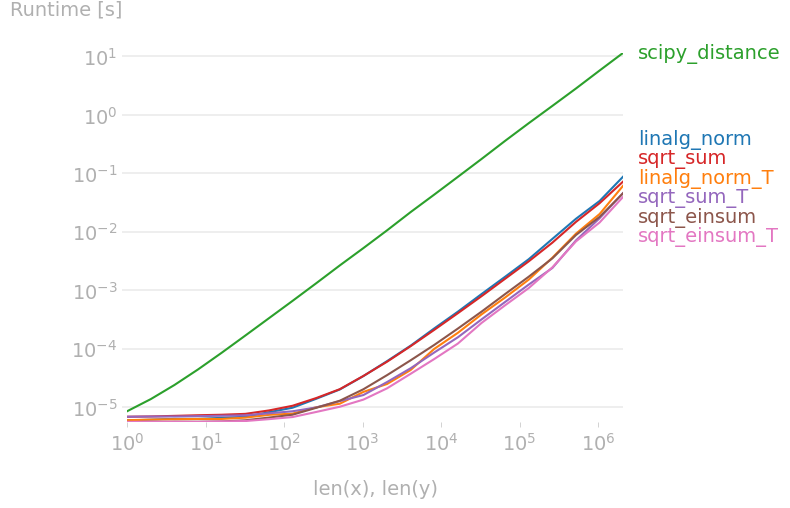

In [33]:
Image("norm.png")

# Display model before / after values

#### parms before

In [68]:
print()
print(f" model device        : {model.device}")
print(f" model temperature   : {model.temperature}")
print(f" model l             : {model.temperature}")
print(f" loss_factor         : {model.loss_factor}")
print(f" monitor_grads_layer : {model.monitor_grads_layer}")
print(f" Learning rate       : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor         : {model.snnl_factor}")
print(f" temperature         : {model.temperature.item()}")
print(f" Temperature LR      : {model.temp_optimizer.param_groups[0]['lr']}") 



 model device        : cuda:0
 model temperature   : Parameter containing:
tensor([50.], device='cuda:0', requires_grad=True)
 model l             : Parameter containing:
tensor([50.], device='cuda:0', requires_grad=True)
 loss_factor         : 2.0
 monitor_grads_layer : None
 Learning rate       : 0.0001
 snnl_factor         : 1.0
 temperature         : 50.0
 Temperature LR      : 0.01


#### scheudler before

In [56]:
model.scheduler.__dict__

AttributeError: 'NoneType' object has no attribute '__dict__'

#### temp_scheudler before

In [57]:
model.temp_scheduler.__dict__

AttributeError: 'NoneType' object has no attribute '__dict__'

#### parms After

In [74]:
print()
print(f" model device        : {model.device}")
print(f" model temperature   : {model.temperature}")
print(f" model l             : {model.temperature}")
print(f" loss_factor         : {model.loss_factor}")
print(f" monitor_grads_layer : {model.monitor_grads_layer}")
print(f" Learning rate       : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor         : {model.snnl_factor}")
print(f" temperature         : {model.temperature.item()}")
print(f" Temperature LR      : {model.temp_optimizer.param_groups[0]['lr']}") 



 model device        : cuda:0
 model temperature   : Parameter containing:
tensor([50.], device='cuda:0', requires_grad=True)
 model l             : Parameter containing:
tensor([50.], device='cuda:0', requires_grad=True)
 loss_factor         : 2.0
 monitor_grads_layer : None
 Learning rate       : 1.5625e-05
 snnl_factor         : 0.5
 temperature         : 50.0
 Temperature LR      : 0.0005


#### scheduler after

In [75]:
model.scheduler.__dict__

{'factor': 0.5,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 1.5625e-05
     maximize: False
     weight_decay: 0
 ),
 'min_lrs': [0],
 'patience': 15,
 'verbose': True,
 'cooldown': 10,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 1e-05,
 'threshold_mode': 'rel',
 'best': 0.5949512794613838,
 'num_bad_epochs': 14,
 'mode_worse': inf,
 'eps': 1e-08,
 'last_epoch': 350,
 '_last_lr': [1.5625e-05]}

#### temp_scheduler after

#### optimizer before

In [92]:
print()
model.optimizer.__dict__

{'defaults': {'lr': 0.0001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': None},
 '_optimizer_step_pre_hooks': OrderedDict(),
 '_optimizer_step_post_hooks': OrderedDict(),
 '_optimizer_state_dict_pre_hooks': OrderedDict(),
 '_optimizer_state_dict_post_hooks': OrderedDict(),
 '_optimizer_load_state_dict_pre_hooks': OrderedDict(),
 '_optimizer_load_state_dict_post_hooks': OrderedDict(),
 '_zero_grad_profile_name': 'Optimizer.zero_grad#Adam.zero_grad',
 'state': defaultdict(dict, {}),
 'param_groups': [{'params': [Parameter containing:
    tensor([[ 0.0215,  0.0341,  0.0676,  ..., -0.0503,  0.0247, -0.0389],
            [ 0.0672, -0.0351, -0.0027,  ...,  0.0202,  0.0175, -0.0390],
            [ 0.0114, -0.0345,  0.0345,  ...,  0.0355,  0.0023, -0.0213],
            ...,
            [-0.0111,  0.0012, -0.0110,  ..., -0.0487, -0.0179,  0.0457],
           

In [79]:
model.temp_scheduler.__dict__

{'factor': 0.5,
 'optimizer': SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.0005
     maximize: False
     momentum: 0.9
     nesterov: False
     weight_decay: 0
 ),
 'min_lrs': [0],
 'patience': 35,
 'verbose': True,
 'cooldown': 15,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 1e-07,
 'threshold_mode': 'rel',
 'best': 2.462797147035599,
 'num_bad_epochs': 0,
 'mode_worse': inf,
 'eps': 1e-08,
 'last_epoch': 50,
 '_last_lr': [0.0005]}

#### optimizer after

In [95]:
print()
model.optimizer.__dict__

{'defaults': {'lr': 0.001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': None},
 'state': defaultdict(dict,
             {Parameter containing:
              tensor([[-0.1078,  0.0057, -0.0510,  ...,  0.0594,  0.1069,  0.0640],
                      [-0.1145, -0.1986, -0.1407,  ...,  0.1411,  0.3946, -0.0203],
                      [-0.0556,  0.0700,  0.0775,  ..., -0.0425,  0.1645,  0.0141],
                      ...,
                      [ 0.0297,  0.0965,  0.0427,  ...,  0.1891,  0.0252, -0.1212],
                      [-0.0689,  0.1369,  0.0458,  ...,  0.0924,  0.0807,  0.0542],
                      [-0.0871,  0.0142, -0.0709,  ..., -0.0739, -0.0889, -0.1526]], device='cuda:0', requires_grad=True): {'step': tensor(240000.),
               'exp_avg': tensor([[-1.3501e-05, -1.5283e-05, -3.0307e-06,  ...,  6.1780e-06,  6.1375e-06,  1.1497e-05],
   

#### temp_optimizers before

In [84]:
print()
model.temp_optimizer.__dict__

{'defaults': {'lr': 0.01,
  'momentum': 0.9,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False},
 '_optimizer_step_pre_hooks': OrderedDict(),
 '_optimizer_step_post_hooks': OrderedDict(),
 '_optimizer_state_dict_pre_hooks': OrderedDict(),
 '_optimizer_state_dict_post_hooks': OrderedDict(),
 '_optimizer_load_state_dict_pre_hooks': OrderedDict(),
 '_optimizer_load_state_dict_post_hooks': OrderedDict(),
 '_zero_grad_profile_name': 'Optimizer.zero_grad#SGD.zero_grad',
 'state': defaultdict(dict, {}),
 'param_groups': [{'params': [Parameter containing:
    tensor([50.], device='cuda:0', requires_grad=True)],
   'lr': 0.01,
   'momentum': 0.9,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False}],
 '_warned_capturable_if_run_uncaptured': True}

In [77]:
print()
model.optimizer.__dict__

{'defaults': {'lr': 0.001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': None},
 'state': defaultdict(dict,
             {Parameter containing:
              tensor([[-0.1078,  0.0057, -0.0510,  ...,  0.0594,  0.1069,  0.0640],
                      [-0.1145, -0.1986, -0.1407,  ...,  0.1411,  0.3946, -0.0203],
                      [-0.0556,  0.0700,  0.0775,  ..., -0.0425,  0.1645,  0.0141],
                      ...,
                      [ 0.0297,  0.0965,  0.0427,  ...,  0.1891,  0.0252, -0.1212],
                      [-0.0689,  0.1369,  0.0458,  ...,  0.0924,  0.0807,  0.0542],
                      [-0.0871,  0.0142, -0.0709,  ..., -0.0739, -0.0889, -0.1526]], device='cuda:0', requires_grad=True): {'step': tensor(240000.),
               'exp_avg': tensor([[-1.3501e-05, -1.5283e-05, -3.0307e-06,  ...,  6.1780e-06,  6.1375e-06,  1.1497e-05],
   

#### temp_optimizer after

In [87]:
print()
model.temp_optimizer.__dict__

{'defaults': {'lr': 0.001,
  'momentum': 0.9,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False},
 'state': defaultdict(dict,
             {Parameter containing:
              tensor([7.4499], device='cuda:0', requires_grad=True): {'momentum_buffer': tensor([0.0517], device='cuda:0')}}),
 'param_groups': [{'params': [Parameter containing:
    tensor([7.4499], device='cuda:0', requires_grad=True)],
   'lr': 0.0005,
   'momentum': 0.9,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False}],
 '_optimizer_step_pre_hooks': OrderedDict(),
 '_optimizer_step_post_hooks': OrderedDict(),
 '_optimizer_state_dict_pre_hooks': OrderedDict(),
 '_optimizer_state_dict_post_hooks': OrderedDict(),
 '_optimizer_load_state_dict_pre_hooks': OrderedDict(),
 '_optimizer_load_state_dict_post_hooks': OrderedDict(),
 '_zero_grad_profile_name': 'Optimizer.zero_

# Load_v2

In [152]:
def load_checkpoint_v2(model, filename, dryrun = False):
    epoch = 9999999
    try:
        checkpoints_folder = os.path.join("ckpts")
        checkpoint = torch.load(os.path.join(checkpoints_folder, filename+'.pt'))
        for key, value in checkpoint.items():
            print(f"{key:40s}, {str(type(value)):60s}  -- model attr set")
            if not dryrun:
                model.__dict__[key] = value
        
        # model.load_state_dict(checkpoint['state_dict'])
        # model.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # if "scheduler" in checkpoint and (hasattr(model, 'scheduler')):
        #     model.scheduler = checkpoint['scheduler']
        # epoch = checkpoint.get('epoch',0)
        print(f"\n ==> Loaded from checkpoint {filename} successfully. last epoch on checkpoint: {epoch}\n")
         
    except FileNotFoundError:
        Exception("Previous state checkpoint not found.")
        print("FileNotFound Exception")
    except :
        print("Other Exception")
        print(sys.exc_info())

    return model, epoch

def save_checkpoint_v2(epoch, model, filename, update_latest=False, update_best=False, verbose = False):
    from types import NoneType
    model_checkpoints_folder = os.path.join("ckpts")
    if not os.path.exists(model_checkpoints_folder):
        print(f"path {model_checkpoints_folder} doesn't exist")
        
    checkpoint = {'epoch'                     : epoch,
                  'state_dict'                : model.state_dict(),
                  'optimizer_state_dict'      : model.optimizer.state_dict(),
                  'temp_optimizer_state_dict' : model.temp_optimizer.state_dict(),
                  'scheduler_state_dict'      : model.scheduler.state_dict() if model.use_scheduler else None,
                  'temp_scheduler_state_dict' : model.temp_scheduler.state_dict() if model.use_temp_scheduler else None ,
                 }
    model_attributes = model.__dict__
    for key, value in model_attributes.items():
        if key not in checkpoint:
            if key[0] == '_' :
                if verbose:
                    print(f"{key:40s}, {str(type(value)):60s} -- {key} in ignore_attributes - will not be added")
            else:
                if verbose:
                    print(f"{key:40s}, {str(type(value)):60s} -- add to checkpoint dict")
                checkpoint['params'][key] = value
        else:
            if verbose:
                print(f"{key:40s}, {str(type(value)):60s} -- {key} already in checkpoint dict")
    if verbose:
        print(checkpoint.keys())    
    if update_latest:
        s_filename = os.path.join(model_checkpoints_folder, f"{filename}_model_latest.pt")
    elif update_best:
        s_filename = os.path.join(model_checkpoints_folder, f"{filename}_model_best.pt")
    else:
        filename = os.path.join(model_checkpoints_folder, f"{filename}.pt")
    print(filename)
    torch.save(checkpoint, filename) 
    print(f"[INFO] Model exported to {filename}.")


def fix_checkpoint_v2 (filename):

    checkpoints_folder = os.path.join("ckpts")
    orig_ckpt_file = os.path.join(checkpoints_folder, filename+'.pt')
    fixed_ckpt_file = os.path.join(checkpoints_folder, filename+'_fixed.pt')
    
    print(f" ==> Original checkpoint: {orig_ckpt_file}")
    print(f" ==> Fixed    checkpoint: {fixed_ckpt_file}")
    
    try:
        checkpoint = torch.load(orig_ckpt_file)
        print(f"\n ==> Loaded from checkpoint {filename} successfully. last epoch on checkpoint: {checkpoint['epoch']}\n")
    except FileNotFoundError:
        Exception("Original checkpoint not found.")
    except :
        print("Other Exception")
        print(sys.exc_info())

    fixed_checkpoint = dict()
    fixed_checkpoint['params'] = dict()
    for key, value in checkpoint.items():
        if key in ['epoch', 'state_dict', 'optimizer_state_dict', 'temp_optimizer_state_dict', 'scheduler_state_dict', 'temp_scheduler_state_dict' ]:
            fixed_checkpoint[key] = value
            print(f"{key:40s}, {str(type(value)):60s}  -- major key set  ")
        else:
            fixed_checkpoint['params'][key] = value
            print(f"{key:40s}, {str(type(value)):60s}  -- params key set  ")
            
    try:
        torch.save(fixed_checkpoint, fixed_ckpt_file) 
        print(f"[INFO] Model exported to { fixed_ckpt_file}.")
    except :
        print("Other Exception 2")
        print(sys.exc_info())

    return  fixed_checkpoint

In [143]:
exp_epoch = 300
exp_name = 'AE'
exp_runmode = 'snnl'
exp_date= '20240507'
exp_title = 'secondTry'
# filename = f"{model.name}_{args.runmode.lower()}_{args.exp_date}_{args.exp_title}_ep_{epoch:03d}_copy.pt"
filename = f"{exp_name}_{exp_runmode}_{exp_date}_{exp_title}_{exp_epoch:03d}_copy"
print(filename)

AE_snnl_20240507_secondTry_300_copy


In [144]:
exp_name   = 'AE'
exp_epochs = 300
exp_mode   = 'snnl'
exp_timestamp = "20240507"
exp_title="secondTry"
# exp_cpb = 100
# exp_factor = 0
# ex_mode = 'baseline'
# ex_title="dropout04"
# title="autoencoder"
# title='Xentropy'
filename = f"{exp_name}_{exp_mode}_{exp_timestamp}_{exp_title}_{exp_epochs:03d}_copy" ## _cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
print(filename)

AE_snnl_20240507_secondTry_300_copy


In [145]:
if os.path.exists(os.path.join('ckpts', filename+'.pt')):
    print(f"\n *** Checkpoint EXISTS *** \n")
else:
    print(f"\n *** Checkpoint DOESNT EXIST *** \n")    


 *** Checkpoint EXISTS *** 



In [146]:
new_checkpoint = fix_checkpoint_v2(filename)

 ==> Original checkpoint: ckpts/AE_snnl_20240507_secondTry_300_copy.pt
 ==> Fixed    checkpoint: ckpts/AE_snnl_20240507_secondTry_300_copy_fixed.pt

 ==> Loaded from checkpoint AE_snnl_20240507_secondTry_300_copy successfully. last epoch on checkpoint: 300

epoch                                   , <class 'int'>                                                 -- major key set  
state_dict                              , <class 'collections.OrderedDict'>                             -- major key set  
optimizer_state_dict                    , <class 'dict'>                                                -- major key set  
temp_optimizer_state_dict               , <class 'dict'>                                                -- major key set  
scheduler_state_dict                    , <class 'dict'>                                                -- major key set  
temp_scheduler_state_dict               , <class 'dict'>                                                -- major key set  
name

In [149]:
new_checkpoint.keys()
new_checkpoint['params'].keys()


dict_keys(['params', 'epoch', 'state_dict', 'optimizer_state_dict', 'temp_optimizer_state_dict', 'scheduler_state_dict', 'temp_scheduler_state_dict'])

dict_keys(['name', 'layer_types', 'layer_activations', 'use_scheduler', 'use_temp_scheduler', 'monitor_grads_layer', 'training', 'mode', 'device', 'train_loss', 'use_snnl', 'loss_factor', 'snnl_factor', 'code_units', 'embedding_layer', 'stability_epsilon', 'verbose', 'sample_size', 'temperatureLR', 'training_history', 'unsupervised', 'use_annealing', 'use_sum', 'optimizer', 'scheduler', 'temp_optimizer', 'temp_scheduler', 'batch_count', 'validation'])

In [114]:

mdl , epc = load_checkpoint_v2(model, filename)  
 

epoch                                   , <class 'int'>                                                 -- model attr set
state_dict                              , <class 'collections.OrderedDict'>                             -- model attr set
optimizer_state_dict                    , <class 'dict'>                                                -- model attr set
temp_optimizer_state_dict               , <class 'dict'>                                                -- model attr set
scheduler_state_dict                    , <class 'dict'>                                                -- model attr set
temp_scheduler_state_dict               , <class 'dict'>                                                -- model attr set
name                                    , <class 'str'>                                                 -- model attr set
layer_types                             , <class 'list'>                                                -- model attr set
layer_activations       

In [98]:
epc

9999

In [73]:
print()
print(f" model device        : {model.device}")
print(f" model temperature   : {model.temperature}")
print(f" model l             : {model.temperature}")
print(f" loss_factor         : {model.loss_factor}")
print(f" monitor_grads_layer : {model.monitor_grads_layer}")
print(f" Learning rate       : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor         : {model.snnl_factor}")
print(f" temperature         : {model.temperature.item()}")
print(f" Temperature LR      : {model.temp_optimizer.param_groups[0]['lr']}") 


 model device        : cuda:0
 model temperature   : Parameter containing:
tensor([50.], device='cuda:0', requires_grad=True)
 model l             : Parameter containing:
tensor([50.], device='cuda:0', requires_grad=True)
 loss_factor         : 2.0
 monitor_grads_layer : None
 Learning rate       : 1.5625e-05
 snnl_factor         : 0.5
 temperature         : 50.0
 Temperature LR      : 0.0005


In [97]:
print()
print(f" model device        : {mdl.device}")
print(f" model temperature   : {mdl.temperature}")
print(f" model l             : {mdl.temperature}")
print(f" loss_factor         : {mdl.loss_factor}")
print(f" monitor_grads_layer : {mdl.monitor_grads_layer}")
print(f" Learning rate       : {mdl.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor         : {mdl.snnl_factor}")
print(f" temperature         : {mdl.temperature.item()}")
print(f" Temperature LR      : {mdl.temp_optimizer.param_groups[0]['lr']}") 


 model device        : cuda:0
 model temperature   : Parameter containing:
tensor([50.], device='cuda:0', requires_grad=True)
 model l             : Parameter containing:
tensor([50.], device='cuda:0', requires_grad=True)
 loss_factor         : 2.0
 monitor_grads_layer : None
 Learning rate       : 1.5625e-05
 snnl_factor         : 0.5
 temperature         : 50.0
 Temperature LR      : 0.0005


In [69]:
def load_model_from_ckpt(model, exmode, timestamp, title, cpb, factor ):
# filename = f"AE_{args.model.lower()}_{date}_{title}_{epochs:03d}_cpb_{args.compounds_per_batch}_factor_{factor}.pt"    
    filename = f"{model.name}_{exmode}_{timestamp}_{title}_{epochs:03d}_cpb_{cpb}_factor_{factor:d}.pt"
    print(filename)
    if os.path.exists(os.path.join('ckpts', filename)):
        print(f"\n *** Checkpoint EXISTS *** \n")
        model, last_epoch = load_checkpoint(model, filename)
        _ = model.eval()
        # model = model.to(current_device)
        # model.to('cpu')
        print(f" model device: {model.device}")
        print(f" model temperature: {model.temperature}")
        print(f" model l: {model.temperature}")
    else:
        print(f"\n *** Checkpoint DOESNT EXIST *** \n")
    return model

In [49]:
print()
model.optimizer.__dict__

{'defaults': {'lr': 0.0001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': None},
 '_optimizer_step_pre_hooks': OrderedDict(),
 '_optimizer_step_post_hooks': OrderedDict(),
 '_optimizer_state_dict_pre_hooks': OrderedDict(),
 '_optimizer_state_dict_post_hooks': OrderedDict(),
 '_optimizer_load_state_dict_pre_hooks': OrderedDict(),
 '_optimizer_load_state_dict_post_hooks': OrderedDict(),
 '_zero_grad_profile_name': 'Optimizer.zero_grad#Adam.zero_grad',
 'state': defaultdict(dict, {}),
 'param_groups': [{'params': [Parameter containing:
    tensor([[ 0.0099,  0.0209,  0.0352,  ..., -0.0118,  0.0566, -0.1130],
            [ 0.0362, -0.0060, -0.0494,  ...,  0.0027,  0.0527,  0.0409],
            [ 0.0696,  0.0426, -0.0060,  ..., -0.0674, -0.0258, -0.0254],
            ...,
            [-0.0090,  0.0015, -0.0364,  ...,  0.0122, -0.0073,  0.0517],
           

In [50]:
print()
model.temp_optimizer.__dict__

{'defaults': {'lr': 0.01,
  'momentum': 0.9,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'foreach': None,
  'differentiable': False},
 '_optimizer_step_pre_hooks': OrderedDict(),
 '_optimizer_step_post_hooks': OrderedDict(),
 '_optimizer_state_dict_pre_hooks': OrderedDict(),
 '_optimizer_state_dict_post_hooks': OrderedDict(),
 '_optimizer_load_state_dict_pre_hooks': OrderedDict(),
 '_optimizer_load_state_dict_post_hooks': OrderedDict(),
 '_zero_grad_profile_name': 'Optimizer.zero_grad#SGD.zero_grad',
 'state': defaultdict(dict, {}),
 'param_groups': [{'params': [Parameter containing:
    tensor([50.], device='cuda:0', requires_grad=True)],
   'lr': 0.01,
   'momentum': 0.9,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False}],
 '_warned_capturable_if_run_uncaptured': True}

# SNNL

In [5]:
# from snnl import SNNLoss
_ = torch.manual_seed(42)

In [6]:
snnl = SNNLoss(temperature=1.0)

 Build SNNLoss dfrom NOTEBOOK
 Building SNNLoss from NOTEBOOK
    SNNLoss _init()_    -- mode: classifier was found in SNNLoss._supported_modes --   is unsupervised: False
    SNNLoss _init()_    -- primary_criterion: CrossEntropyLoss()
    SNNLoss _init()_    -- unsupervised :     False
    SNNLoss _init()_    -- use_annealing :    False
    SNNLoss _init()_    -- sample_size :      1


In [7]:
features = torch.rand((4, 2))

In [312]:
features = torch.Tensor([[1.0, 1.0],
                         [2.0, 2.0],
                         [-1.0, -1.0],
                         [-2.0, -2.0]]
                       )
features = torch.Tensor([[2.0, 2.0],
                         [-2.0, -2.0]])
features = torch.Tensor([[0.02, 0.02],
                         [0.1, 0.1],
                         [1.02, 1.02],
                         [2.00, 2.00]])
features

tensor([[0.0200, 0.0200],
        [0.1000, 0.1000],
        [1.0200, 1.0200],
        [2.0000, 2.0000]])

In [313]:
labels = torch.Tensor([[0.0],[0.0],[0.0],[0.0]])
# labels = torch.Tensor([[0.0],[0.0]])
# labels = torch.Tensor([[0.0],[0.0],[0.0]])
labels.shape

torch.Size([4, 1])

In [321]:
snnl.sample_size = 1
snnl.temperature = 2.2

In [322]:
snnl.distance_matrix = snnl.pairwise_cosine_distance(features)
snnl.distance_matrix

snnl.pairwise_distance_matrix = snnl.normalize_distance_matrix(features=features, distance_matrix=snnl.distance_matrix, device='cpu')
snnl.pairwise_distance_matrix

tensor([[ 5.9605e-08,  5.9605e-08,  0.0000e+00,  5.9605e-08],
        [ 5.9605e-08,  5.9605e-08,  0.0000e+00,  5.9605e-08],
        [ 0.0000e+00,  0.0000e+00, -1.1921e-07,  0.0000e+00],
        [ 5.9605e-08,  5.9605e-08,  0.0000e+00,  5.9605e-08]])

tensor([[0., 1., 1., 1.],
        [1., 0., 1., 1.],
        [1., 1., 0., 1.],
        [1., 1., 1., 0.]])

In [323]:
snnl.pick_probability = snnl.compute_sampling_probability(snnl.pairwise_distance_matrix)
snnl.pick_probability

tensor([[0.0000, 0.3333, 0.3333, 0.3333],
        [0.3333, 0.0000, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.0000, 0.3333],
        [0.3333, 0.3333, 0.3333, 0.0000]])

In [324]:
snnl.summed_masked_pick_probability = snnl.mask_sampling_probability(labels, snnl.pick_probability, device='cpu')

In [325]:
snnl.masking_matrix
snnl.masked_pick_probability
snnl.summed_masked_pick_probability
-torch.log(snnl.stability_epsilon + snnl.summed_masked_pick_probability)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

tensor([0., 0., 0., 0.])

tensor([11.5129, 11.5129, 11.5129, 11.5129])

In [326]:
snnl.final =  torch.mean( -torch.log(snnl.stability_epsilon + snnl.summed_masked_pick_probability))
snnl.final

tensor(11.5129)

In [327]:
x = []
y = []

for t in range(1,+50,+1):
    # if t == 0:
    #     continue
    snnl.temperature = t
    snnl.distance_matrix = snnl.pairwise_cosine_distance(features)
    snnl.pairwise_distance_matrix = snnl.normalize_distance_matrix(features=features, distance_matrix=snnl.distance_matrix, device='cpu')
    snnl.pick_probability = snnl.compute_sampling_probability(snnl.pairwise_distance_matrix)
    snnl.summed_masked_pick_probability = snnl.mask_sampling_probability(labels, snnl.pick_probability, device='cpu')
    snnl.final =  torch.mean( -torch.log(snnl.stability_epsilon + snnl.summed_masked_pick_probability))
    x.append(t)
    y.append(snnl.final)

49

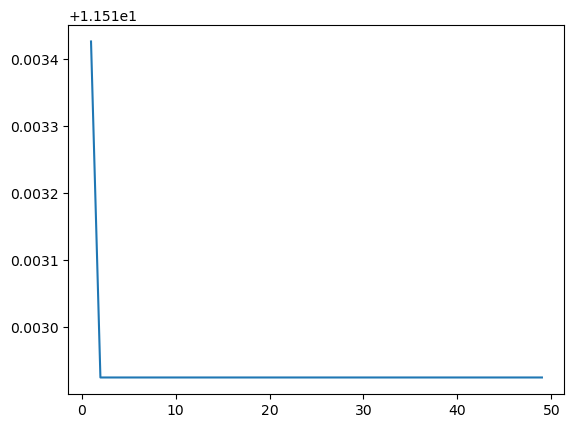

In [328]:
len(x)
plt.plot(x,y)

In [329]:
x = []
y = []


for t in np.arange(1.0,+5.0,+0.01):
    # if t == 0:
    #     continue
    snnl.temperature = t
    snnl.distance_matrix = snnl.pairwise_cosine_distance(features)
    snnl.pairwise_distance_matrix = snnl.normalize_distance_matrix(features=features, distance_matrix=snnl.distance_matrix, device='cpu')
    snnl.pick_probability = snnl.compute_sampling_probability(snnl.pairwise_distance_matrix)
    snnl.summed_masked_pick_probability = snnl.mask_sampling_probability(labels, snnl.pick_probability, device='cpu')
    snnl.final =  torch.mean( -torch.log(snnl.stability_epsilon + snnl.summed_masked_pick_probability))
    x.append(t)
    y.append(snnl.final)

400

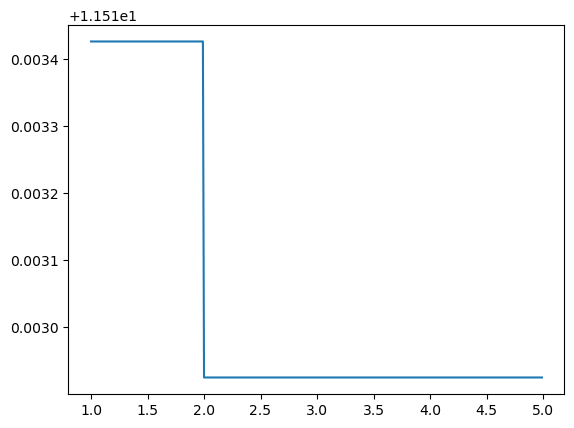

In [330]:
len(x)
plt.plot(x,y)

In [60]:
# self.distance_matrix = self.pairwise_cosine_distance(features=value)

# self.pairwise_distance_matrix = self.normalize_distance_matrix(features=value, 
#                                                                distance_matrix=self.distance_matrix, 
#                                                                device=model.device)

# self.pick_probability = self.compute_sampling_probability(self.pairwise_distance_matrix)

# self.summed_masked_pick_probability = self.mask_sampling_probability(labels, 
#                                                                      self.pick_probability, 
#                                                                      device=model.device)

# snnl = torch.mean( -torch.log(self.stability_epsilon + self.summed_masked_pick_probability))

In [18]:
1/0.092200
1/50.

10.845986984815617

0.02

## e**-t

In [15]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams.update({
    "text.usetex": True,
})
plt.rcParams['text.usetex'] = True

In [16]:
x = []
y1 = []
y2 = []
y3 = []
y4 = []
y5 = []
y6 = []
diff = 0.2
dist1 = 0.01
dist2 = 1.00
temp  = 5.0
for temp in  np.arange(1,20,0.1):
    # temp1 = np.exp(-(dist1))
    temp2 = np.exp(-(dist1/temp))
    # temp3 = np.exp(-(dist2))
    temp4 = np.exp(-(dist2/temp))
    temp5 = temp2/temp4
    temp6 = -np.log(temp5)
    # temp3 = -np.log(np.exp(-ep)/np.exp(-(ep+diff)))
    # temp3 = 1.0 / ((1.0 + ep) ** 0.55)
    x.append(temp)
    # y1.append(temp1)
    y2.append(temp2)
    # y3.append(temp3)
    y4.append(temp4)
    y5.append(temp5)
    y6.append(temp6)


# plt.plot(x,y1,color='b')
plt.plot(x,y2,   '--b', )
# plt.plot(x,y3,color='r')
plt.plot(x,y4,   '--r')
plt.plot(x,y5,   '--g')
plt.plot(x,y6,   '-c')
# plt.legend([r'e^{dist}{T}','b','c',"d"])
ax.set_title(r'\TeX\ is Number $\displaystyle\sum_{n=1}^\infty'
             r'\frac{-e^{i\pi}}{2^n}$!', fontsize=16, color='r')
# df = pd.DataFrame(dict(
    # x=x,
    # y=y1,
    # moa=pd.concat([treated_wells["MOA"], treatments["MOA"]]),
    # batch=pd.concat([treated_wells["Plate"].apply(lambda x: x.split("_")[0]), treatments["Batch"]]),
    # compound=pd.concat([treated_wells["Compound"], treatments["Compound"]]),
    # correct=pd.concat([treated_wells["nsc"],treatments["nsc"]]),
    # level=pd.concat([treated_wells["level"],treatments["level"]])
# ))

# plt.figure()
# sb.lmplot(x,y1, fit_reg=False, palette="hls")

NameError: name 'ax' is not defined

Error in callback <function _draw_all_if_interactive at 0x7f43748e1760> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpby31fs8g 7047aaa5111e4d8dda9c547b5b45d07c.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./7047aaa5111e4d8dda9c547b5b45d07c.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.9 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmpby31fs8g/7047aaa5111e4d8dda9c547b5b45d07c.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpu5ivg50f 7047aaa5111e4d8dda9c547b5b45d07c.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./7047aaa5111e4d8dda9c547b5b45d07c.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.9 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on tmpu5ivg50f/7047aaa5111e4d8dda9c547b5b45d07c.log.




<Figure size 640x480 with 1 Axes>

In [52]:
y1[0], y1[-1]
y2

(0.9900498337491681, 0.9900498337491681)

[0.9900498337491681,
 0.9950124791926823,
 0.9966722160545233,
 0.9975031223974601,
 0.9980019986673331,
 0.9983347214509387,
 0.9985724484938566,
 0.9987507809245809,
 0.9988895059442793,
 0.999000499833375,
 0.9990913221888589,
 0.9991670137924583,
 0.9992310650129109,
 0.9992859693270274,
 0.9993335555061811,
 0.9993751952718163,
 0.9994119376823444,
 0.9994445987368581,
 0.9994738226903856,
 0.9995001249791693,
 0.9995239228844999,
 0.9995455578355891,
 0.999565311895566,
 0.9995834201268338,
 0.9996000799893344,
 0.9996154585703999,
 0.9996296982082685,
 0.9996429209107757,
 0.9996552318599922,
 0.9996667222160499,
 0.9996774713783809,
 0.9996875488230391,
 0.9996970156060145,
 0.9997059256012962,
 0.9997143265267252,
 0.9997222607988971,
 0.9997297662494491,
 0.9997368767282647,
 0.99974362261389,
 0.999750031247396,
 0.9997561273027574,
 0.9997619331043265,
 0.9997674689000131,
 0.9997727530972171,
 0.999777802467307,
 0.9997826323234296,
 0.9997872566756243,
 0.9997916883665486

## annealing

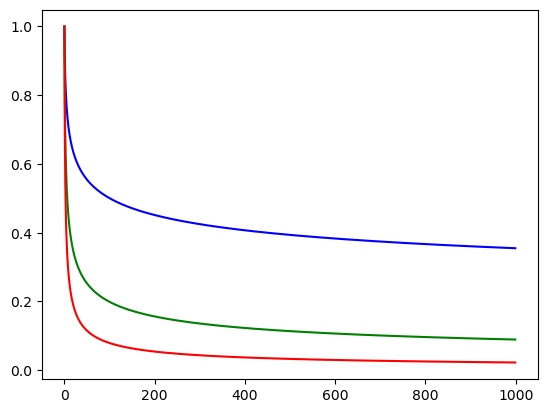

In [17]:
x = []
y1 = []
y2 = []
y3 = []

for ep in  range(1000):
    temp1 = 1.0 / ((1.0 + ep) ** 0.15)
    temp2 = 1.0 / ((1.0 + ep) ** 0.35)
    temp3 = 1.0 / ((1.0 + ep) ** 0.55)
    x.append(ep)
    y1.append(temp1)
    y2.append(temp2)
    y3.append(temp3)

plt.plot(x,y1,color='b')
plt.plot(x,y2,color='green')
plt.plot(x,y3,color='r')